# Feature expansion

Spoiler Alert! By combining feature expansion and feature selection we can increase our logistic regression model accuracy (on previously unseen data) from 79% to 84%!

Simple models such as logistic regression do not incorporate complex interactions between features. If two features produce more than an additive effect, this will not be fitted in logistic regression. In order to allow for feature interaction we need to add terms that create new features by producing the product of each product pair.

When we use polynomial expansion of features, we create new features that are the product of two features. For example if we had two features, A, B and C, a full polynomial expansion would produce the following extra features:

* A.A, A.B, A.C
* B.A, B.B, B.C
* C.A, C.B, C.C

But we will reduce this in two ways:

* Remove duplicate terms (e.g. A.B and B.A are the same, so we only need A.B)
* Use the `interaction_only` argument to remove powers of single features (e.g. A.A, B.B)

A danger of polynomial expansion is that the model may start to over-fit to the training data. This may be dealt with in one (or both of two ways):

* Increase the regularisation strength in the model (reduce the value of `C` in the logistic regression model)
* Use feature selection to pick only the most important features (which now may include polynomial features)

## Load modules

In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold

# Download data

Run the following code if data for Titanic survival has not been previously downloaded.

In [2]:
download_required = True

if download_required:
    
    # Download processed data:
    address = 'https://raw.githubusercontent.com/MichaelAllen1966/' + \
                '1804_python_healthcare/master/titanic/data/processed_data.csv'
    
    data = pd.read_csv(address)

    # Create a data subfolder if one does not already exist
    import os
    data_directory ='./data/'
    if not os.path.exists(data_directory):
        os.makedirs(data_directory)

    # Save data
    data.to_csv(data_directory + 'processed_data.csv', index=False)

## Load data

In [3]:
data = pd.read_csv('data/processed_data.csv')
# Make all data 'float' type
data = data.astype(float)

In [4]:
# Drop Passengerid (axis=1 indicates we are removing a column rather than a row)
data.drop('PassengerId', inplace=True, axis=1)

## Divide into X (features) and y (labels)

In [5]:
# Split data into two DataFrames
X_df = data.drop('Survived',axis=1)
y_df = data['Survived']

# Convert to NumPy arrays
X = X_df.values
y = y_df.values

In [6]:
# Add polynomial features
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
X_poly = poly.fit_transform(X_df)

Let's look at the shape of our data sets (the first value is the number of samples, and the second value is the number of features):

In [7]:
print ('Shape of X:', X.shape)
print ('Shape of X_poly:', X_poly.shape)

Shape of X: (891, 24)
Shape of X_poly: (891, 300)


Woah - we've gone from 24 features to 301! But are they any use?

## Training and testing normal and expanded models with varying regularisation

The following code:
* Defines a list of regularisation (lower values lead to greater regularisation)
* Sets up lists to hold results for each k-fold split
* Starts a loop for each regularisation value, and loops through:
    * Print regularisation level (to show progress)
    * Sets up lists to record replicates from k-fold stratification
    * Sets up the k-fold splits using sklearn's `StratifiedKFold` method
    * Trains two logistic regression models (regular and polynomial), and test its it, for each k-fold split
    * Adds each k-fold training/test accuracy to the lists
* Record average accuracy from k-fold stratification (so each regularisation level has one accuracy result recorded for training and test sets)

We pass the regularisation to the model during fitting, it has the argument name `C`.

In [8]:
# Define function to standardise data

def standardise_data(X_train, X_test):
    
    # Initialise a new scaling object for normalising input data
    sc = StandardScaler() 

    # Set up the scaler just on the training set
    sc.fit(X_train)

    # Apply the scaler to the training and test sets
    train_std=sc.transform(X_train)
    test_std=sc.transform(X_test)
    
    return train_std, test_std

In [9]:
# Training and testing normal and polynomial models

reg_values = [0.001, 0.003, 0.01, 0.03, 0.1, 0.3, 1, 3, 10]

# Set up lists to hold results
training_acc_results = []
test_acc_results = []
training_acc_results_poly = []
test_acc_results_poly = []

# Set up splits
skf = StratifiedKFold(n_splits = 5)
skf.get_n_splits(X, y)
skf.get_n_splits(X_poly, y)

# Set up model type

for reg in reg_values:
    # Show progress
    print(reg, end=' ')
    
    # Set up lists for results for each of k splits
    training_k_results = []
    test_k_results = []
    training_k_results_poly = []
    test_k_results_poly = []
    # Loop through the k-fold splits
    for train_index, test_index in skf.split(X, y):
        
        # Normal (non-polynomial model)
        
        # Get X and Y train/test
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        # Fit model with regularisation (C)
        model = LogisticRegression(C=reg, solver='lbfgs', max_iter=1000)
        model.fit(X_train_std,y_train)
        # Predict training and test set labels
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)
        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)
        # Record accuracy for each k-fold split
        training_k_results.append(accuracy_train)
        test_k_results.append(accuracy_test)
        
        # Polynomial model (same as above except use X with polynomial features)
        
        # Get X and Y train/test
        X_train, X_test = X_poly[train_index], X_poly[test_index]
        y_train, y_test = y[train_index], y[test_index]
        # Standardise X data
        X_train_std, X_test_std = standardise_data(X_train, X_test)
        # Fit model with regularisation (C)
        model = LogisticRegression(C=reg, solver='lbfgs', max_iter=1000)
        model.fit(X_train_std,y_train)
        # Predict training and test set labels
        y_pred_train = model.predict(X_train_std)
        y_pred_test = model.predict(X_test_std)
        # Calculate accuracy of training and test sets
        accuracy_train = np.mean(y_pred_train == y_train)
        accuracy_test = np.mean(y_pred_test == y_test)
        # Record accuracy for each k-fold split
        training_k_results_poly.append(accuracy_train)
        test_k_results_poly.append(accuracy_test)
        
    # Record average accuracy for each k-fold split
    training_acc_results.append(np.mean(training_k_results))
    test_acc_results.append(np.mean(test_k_results))
    training_acc_results_poly.append(np.mean(training_k_results_poly))
    test_acc_results_poly.append(np.mean(test_k_results_poly))

0.001 0.003 0.01 0.03 0.1 0.3 1 3 10 

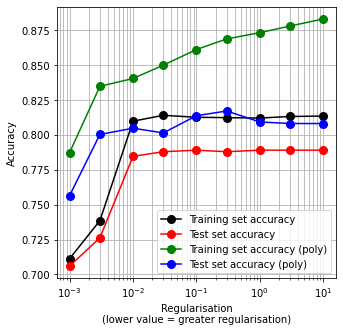

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline

# Define data for chart
x = reg_values
y1 = training_acc_results
y2 = test_acc_results
y3 = training_acc_results_poly
y4 = test_acc_results_poly

# Set up figure
fig = plt.figure(figsize=(5,5))
ax1 = fig.add_subplot(111)

# Plot training set accuracy
ax1.plot(x, y1,
        color = 'k',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='k',
        markeredgecolor='k',
        label  = 'Training set accuracy')

# Plot test set accuracy
ax1.plot(x, y2,
        color = 'r',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='r',
        markeredgecolor='r',
        label  = 'Test set accuracy')

# Plot training set accuracy (poly model)
ax1.plot(x, y3,
        color = 'g',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='g',
        markeredgecolor='g',
        label  = 'Training set accuracy (poly)')

# Plot test set accuracy (poly model)
ax1.plot(x, y4,
        color = 'b',
        linestyle = '-',
        markersize = 8,
        marker = 'o',
        markerfacecolor='b',
        markeredgecolor='b',
        label  = 'Test set accuracy (poly)')

# Customise axes
ax1.grid(True, which='both')
ax1.set_xlabel('Regularisation\n(lower value = greater regularisation)')
ax1.set_ylabel('Accuracy')
ax1.set_xscale('log')

# Add legend
ax1.legend()

# Show plot
plt.show()

Show best test set accuracy measured.

In [11]:
best_test_non_poly = np.max(test_acc_results)
best_test_poly = np.max(test_acc_results_poly)
print ('Best accuracy for non-poly and poly were {0:0.3f} and {1:0.3f}'.format(
    best_test_non_poly, best_test_poly))

Best accuracy for non-poly and poly were 0.789 and 0.817


Note in the above figure that:

* Polynomial expansion has increased the accuracy of both training and test sets. Test set accuracy was increased over 2%
* We do not know which polynomial terms are most useful (below we will use feature reduction to identify those)
* The polynomial X data suffers from more over-fitting than the non-polynomial set (there is a larger difference between training and test set accuracies)

## Feature reduction after feature expansion

We will revisit the code we have used previously to pick the best features.

https://github.com/MichaelAllen1966/1804_python_healthcare/blob/master/titanic/08_feature_selection_2_forward.ipynb

In the previous method we ranked all features in their ability to improve model performance. Here, because there are many more features we will look at the influence of the top 20 (and if we see model performance is still increasing with additional features we could come back and change that limit).

We will amend the previous code as well to use simple accuracy (rather than the ROC Area Under Curve in our previous example).

In [12]:
# Transfer polynomial X into a pandas DataFrame (as method use Pandas)
X_poly_df = pd.DataFrame(X_poly, columns=poly.get_feature_names())

# Create list to store accuracies and chosen features
accuracy_by_feature_number = []
chosen_features = []

# Initialise chosen features list and run tracker
available_features = list(poly.get_feature_names())
run = 0
number_of_features = len(list(X))

# Loop through feature list to select next feature
maximum_features_to_choose = 20

for i in range(maximum_features_to_choose):

    # Track and pront progress
    run += 1
    print ('Feature run {} of {}'.format(run, maximum_features_to_choose))
    
    # Reset best feature and accuracy
    best_result = 0
    best_feature = ''

    # Loop through available features
    for feature in available_features:

        # Create copy of already chosen features to avoid original being changed
        features_to_use = chosen_features.copy()
        # Create a list of features from features already chosen + 1 new feature
        features_to_use.append(feature)
        # Get data for features, and convert to NumPy array
        X_np = X_poly_df[features_to_use].values
        
        # Set up lists to hold results for each selected features
        test_accuracy_results = []
    
        # Set up k-fold training/test splits
        number_of_splits = 5
        skf = StratifiedKFold(n_splits = number_of_splits)
        skf.get_n_splits(X_np, y)
    
        # Loop through the k-fold splits
        for train_index, test_index in skf.split(X_np, y):
            
            # Get X and Y train/test
            X_train, X_test = X_np[train_index], X_np[test_index]
            y_train, y_test = y[train_index], y[test_index]
    
            # Get X and Y train/test
            X_train_std, X_test_std = standardise_data(X_train, X_test)
    
            # Set up and fit model
            model = LogisticRegression(solver='lbfgs')
            model.fit(X_train_std,y_train)
    
            # Predict test set labels
            y_pred_test = model.predict(X_test_std)
                        
            # Calculate accuracy of test sets
            accuracy_test = np.mean(y_pred_test == y_test)
            test_accuracy_results.append(accuracy_test)
          
        # Get average result from all k-fold splits
        feature_accuracy = np.mean(test_accuracy_results)
    
        # Update chosen feature and result if this feature is a new best
        if feature_accuracy > best_result:
            best_result = feature_accuracy
            best_feature = feature
    
    # k-fold splits are complete    
    # Add mean accuracy and AUC to record of accuracy by feature number
    accuracy_by_feature_number.append(best_result)
    chosen_features.append(best_feature)
    available_features.remove(best_feature)

# Put results in DataFrame
results = pd.DataFrame()
results['feature to add'] = chosen_features
results['accuracy'] = accuracy_by_feature_number

Feature run 1 of 20
Feature run 2 of 20
Feature run 3 of 20
Feature run 4 of 20
Feature run 5 of 20
Feature run 6 of 20
Feature run 7 of 20
Feature run 8 of 20
Feature run 9 of 20
Feature run 10 of 20
Feature run 11 of 20
Feature run 12 of 20
Feature run 13 of 20
Feature run 14 of 20
Feature run 15 of 20
Feature run 16 of 20
Feature run 17 of 20
Feature run 18 of 20
Feature run 19 of 20
Feature run 20 of 20


In [13]:
results

,feature to add,accuracy
0,x1 x10,0.792361
1,x0 x2,0.818153
2,x19,0.824895
3,x3 x12,0.829402
4,x2 x16,0.832760
5,x13,0.835001
6,x3 x10,0.836131
7,x0 x3,0.839489
8,x8 x19,0.840619
9,x3 x5,0.841743


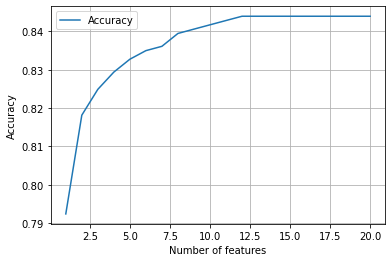

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

chart_x = list(range(1, maximum_features_to_choose+1))

plt.plot(chart_x, accuracy_by_feature_number,
        label = 'Accuracy')

plt.xlabel('Number of features')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.show()

Neat! By selecting our best features from our expanded model we now have a little over 84% accuracy! It looks like we need about 15 features for our optimum model, nearly all of which are polynomial terms. Note that sklearn's polynomial method outputs features names in relation to the original X index. Our 'best' feature is a product of X1 and X10. Let's see what those are:

In [15]:
X_index_names = list(X_df)
print ('X1:',X_index_names[1])
print ('X10:',X_index_names[10])

X1: Age
X10: male


So looking at just the ages of male passengers is the best single predictor of survival.